## Milestone II - Exploratory Data Analysis

EDA for the multi-domain recession forecasting dataset.

### Import Packages and Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Load the dataset
df = pd.read_pickle('data/milestone_ii_dataset.pkl')
print(f"Dataset shape: {df.shape}")
print(f"Date range: {df.index.get_level_values('date').min()} to {df.index.get_level_values('date').max()}")
print(f"Countries: {df.index.get_level_values('country').unique().tolist()}")

Dataset shape: (5508, 233)
Date range: 1970-01-01 00:00:00 to 2020-12-01 00:00:00
Countries: ['Australia', 'Canada', 'France', 'Germany', 'Italy', 'Japan', 'South Korea', 'UK', 'USA']


### 1. Missing Values Analysis

In [2]:
# Calculate missing values by feature
missing = df.isnull().sum().sort_values(ascending=False)
missing_pct = (missing / len(df) * 100).round(2)

# Display features with missing values
missing_df = pd.DataFrame({'missing_count': missing, 'missing_pct': missing_pct})
missing_df = missing_df[missing_df['missing_count'] > 0]
print(f"Features with missing values: {len(missing_df)} / {len(df.columns)}")
print("\nTop 20 features by missing percentage:")
print(missing_df.head(20))

Features with missing values: 219 / 233

Top 20 features by missing percentage:
                                missing_count  missing_pct
retail_vol_log_1mo                       3861        70.10
retail_vol_log_12mo                      3745        67.99
retail_vol_log_6mo                       3689        66.98
copper_log_12mo                          3672        66.67
retail_vol_log_3mo                       3641        66.10
copper_log_6mo                           3618        65.69
copper_log_3mo                           3591        65.20
copper_log_1mo                           3573        64.87
copper                                   3564        64.71
epu_rolling_mean_12mo_lag_12mo           2475        44.93
epu_rolling_mean_6mo_lag_12mo            2421        43.95
epu_rolling_mean_12mo_lag_6mo            2421        43.95
epu_rolling_mean_3mo_lag_12mo            2394        43.46
epu_rolling_mean_12mo_lag_3mo            2394        43.46
epu_log_12mo                       

In [3]:
# Find earliest date with complete data for each country
complete_dates = []
for country in df.index.get_level_values('country').unique():
    country_df = df.xs(country, level='country')
    # First row with no missing values
    complete_mask = ~country_df.isnull().any(axis=1)
    if complete_mask.any():
        first_complete = country_df[complete_mask].index.min()
        complete_dates.append({'country': country, 'first_complete_date': first_complete})

complete_df = pd.DataFrame(complete_dates)
print("First date with complete data by country:")
print(complete_df.sort_values('first_complete_date'))
print(f"\nRecommended start date for analysis: {complete_df['first_complete_date'].max()}")

First date with complete data by country:
       country first_complete_date
0    Australia          2004-01-01
2       France          2004-01-01
7           UK          2004-01-01
3      Germany          2004-04-01
8          USA          2004-08-01
1       Canada          2005-02-01
6  South Korea          2005-06-01
5        Japan          2005-07-01
4        Italy          2006-07-01

Recommended start date for analysis: 2006-07-01 00:00:00


### 2. Target Distribution

In [4]:
# Overall target distribution
print("Target Distribution (pre_recession):")
print(df['pre_recession'].value_counts())
print(f"\nClass imbalance ratio: {df['pre_recession'].value_counts()[0] / df['pre_recession'].value_counts()[1]:.1f}:1")
print(f"Positive class percentage: {df['pre_recession'].mean():.2%}")

Target Distribution (pre_recession):
pre_recession
0    4334
1    1174
Name: count, dtype: int64

Class imbalance ratio: 3.7:1
Positive class percentage: 21.31%


In [5]:
# Pre-recession periods by country
pre_rec_by_country = df.groupby(level='country')['pre_recession'].agg(['sum', 'mean'])
pre_rec_by_country.columns = ['pre_recession_months', 'pre_recession_pct']
pre_rec_by_country['pre_recession_pct'] = pre_rec_by_country['pre_recession_pct'].map('{:.2%}'.format)
print("Pre-recession periods by country:")
print(pre_rec_by_country)

Pre-recession periods by country:
             pre_recession_months pre_recession_pct
country                                            
Australia                     148            24.18%
Canada                        144            23.53%
France                        120            19.61%
Germany                       128            20.92%
Italy                         127            20.75%
Japan                         135            22.06%
South Korea                   144            23.53%
UK                            108            17.65%
USA                           120            19.61%


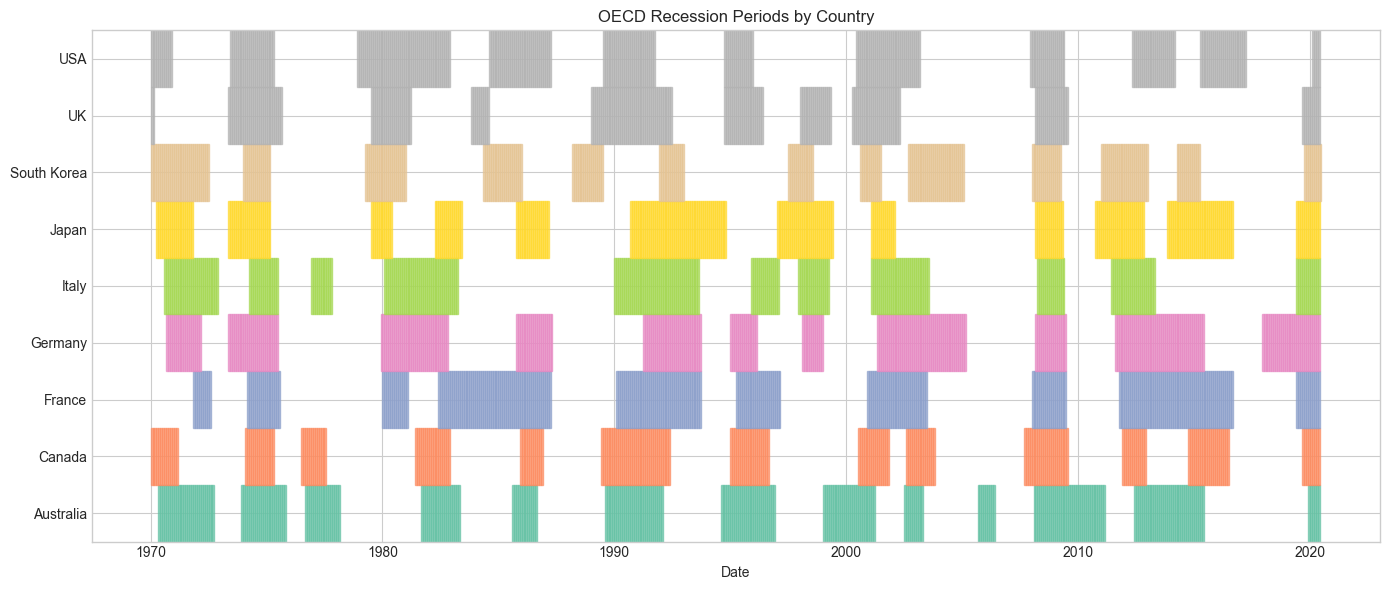

In [6]:
# Visualize recession timing across countries
fig, ax = plt.subplots(figsize=(14, 6))

countries = df.index.get_level_values('country').unique()
colors = plt.cm.Set2(np.linspace(0, 1, len(countries)))

for i, country in enumerate(countries):
    country_df = df.xs(country, level='country')
    recession_periods = country_df[country_df['oecd_rec'] == True].index
    
    for date in recession_periods:
        ax.axvspan(date, date + pd.DateOffset(months=1), 
                   ymin=i/len(countries), ymax=(i+1)/len(countries),
                   alpha=0.7, color=colors[i], label=country if date == recession_periods[0] else '')

ax.set_yticks([(i + 0.5) / len(countries) for i in range(len(countries))])
ax.set_yticklabels(countries)
ax.set_xlabel('Date')
ax.set_title('OECD Recession Periods by Country')
plt.tight_layout()
plt.show()

### 3. Feature Distributions

In [7]:
# Summary statistics for key raw indicators
raw_indicators = ['real_gdp', 'cpi', 'unemployment_rate', '10_yr_yld', '3_mo_yld', 
                  'vix', 'oil', 'epu', 'yield_curve', 'sahm_value']
raw_indicators = [c for c in raw_indicators if c in df.columns]

print("Summary Statistics for Key Indicators:")
df[raw_indicators].describe().round(2)

Summary Statistics for Key Indicators:


,real_gdp,cpi,unemployment_rate,10_yr_yld,3_mo_yld,vix,oil,epu,yield_curve,sahm_value
count,4.509000e+03,5307.00,4451.00,4657.00,4572.00,3348.00,5508.00,3240.00,4306.00,4334.00
mean,3.721453e+13,66.92,6.74,6.09,5.63,19.48,36.02,129.01,0.82,0.33
std,8.811005e+13,28.97,2.76,3.79,4.71,7.77,27.51,84.96,1.51,0.68
min,1.247300e+11,4.64,1.00,-0.65,-0.54,10.13,3.31,11.29,-13.30,0.00
25%,3.405420e+11,44.66,4.62,3.18,1.66,13.93,16.75,77.44,0.07,0.00
50%,5.085678e+11,71.90,6.80,5.54,4.86,17.55,27.54,104.82,0.91,0.07
75%,1.536685e+13,93.34,8.80,8.68,8.60,23.22,49.78,149.97,1.79,0.37
max,4.696068e+14,109.90,14.80,17.32,23.10,62.67,133.93,1141.80,5.57,9.43


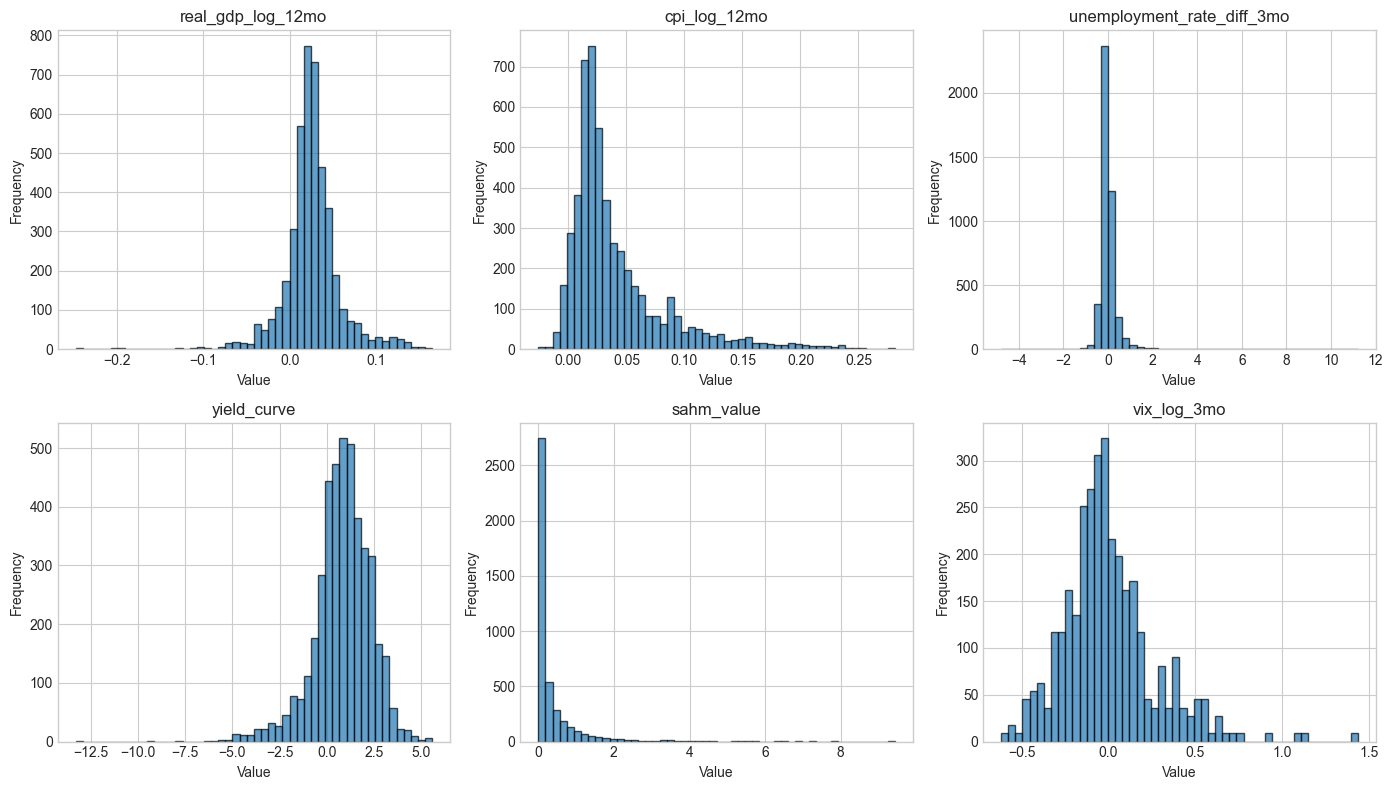

In [8]:
# Distribution plots for key transformed features
transformed_features = ['real_gdp_log_12mo', 'cpi_log_12mo', 'unemployment_rate_diff_3mo',
                        'yield_curve', 'sahm_value', 'vix_log_3mo']
transformed_features = [c for c in transformed_features if c in df.columns]

fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()

for i, col in enumerate(transformed_features):
    df[col].dropna().hist(bins=50, ax=axes[i], edgecolor='black', alpha=0.7)
    axes[i].set_title(col)
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

### 4. Correlation Analysis

In [9]:
# Feature correlations with target
# Exclude one-hot encoded country columns and boolean columns
feature_cols = [c for c in df.columns if not c.startswith('country_') 
                and c not in ['pre_recession', 'oecd_rec', 'technical_rec']]

target_corr = df[feature_cols].corrwith(df['pre_recession']).sort_values(key=abs, ascending=False)

print("Top 20 features correlated with pre_recession target:")
print(target_corr.head(20).round(3))

print("\nBottom 20 features (negative correlation):")
print(target_corr.tail(20).round(3))

Top 20 features correlated with pre_recession target:
cli_lag_1mo                       0.358
cli_dev_lag_1mo                   0.358
cli_dev                           0.357
cli                               0.357
cli_dev_lag_3mo                   0.341
cli_lag_3mo                       0.341
cli_lag_6mo                       0.276
cli_dev_lag_6mo                   0.276
copper                            0.270
ind_out_log_12mo                  0.247
unemployment_rate_diff_12mo      -0.219
real_gdp_log_12mo                 0.206
comp_consumer_conf_lag_3mo        0.205
comp_consumer_conf_dev_lag_3mo    0.205
comp_consumer_conf_lag_1mo        0.203
comp_consumer_conf_dev_lag_1mo    0.203
cli_diff_12mo                     0.198
comp_consumer_conf_dev            0.195
comp_consumer_conf                0.195
3_mo_yld_diff_6mo                 0.193
dtype: float64

Bottom 20 features (negative correlation):
ind_out                                           0.008
yield_curve_lag_1mo            

c:\Users\Matthew\Desktop\School\Milestone 2\Repo\.venv\Lib\site-packages\numpy\_core\_methods.py:132: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


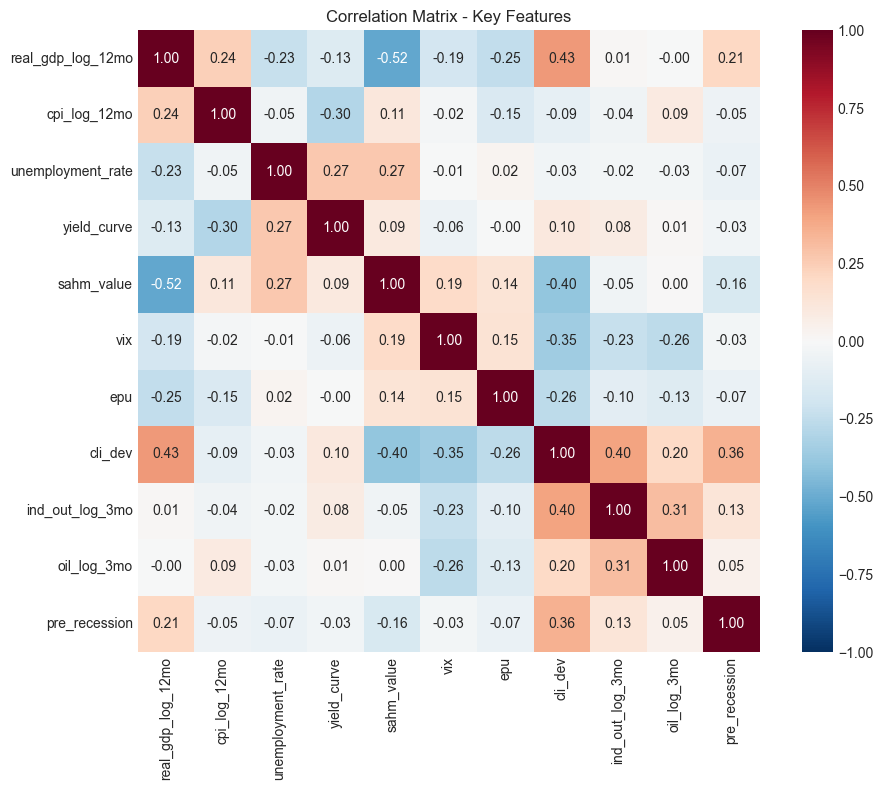

In [10]:
# Correlation heatmap for key features
key_features = ['real_gdp_log_12mo', 'cpi_log_12mo', 'unemployment_rate', 
                'yield_curve', 'sahm_value', 'vix', 'epu', 'cli_dev',
                'ind_out_log_3mo', 'oil_log_3mo', 'pre_recession']
key_features = [c for c in key_features if c in df.columns]

corr_matrix = df[key_features].corr()

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            square=True, ax=ax, vmin=-1, vmax=1)
ax.set_title('Correlation Matrix - Key Features')
plt.tight_layout()
plt.show()

### 5. Time Series Patterns

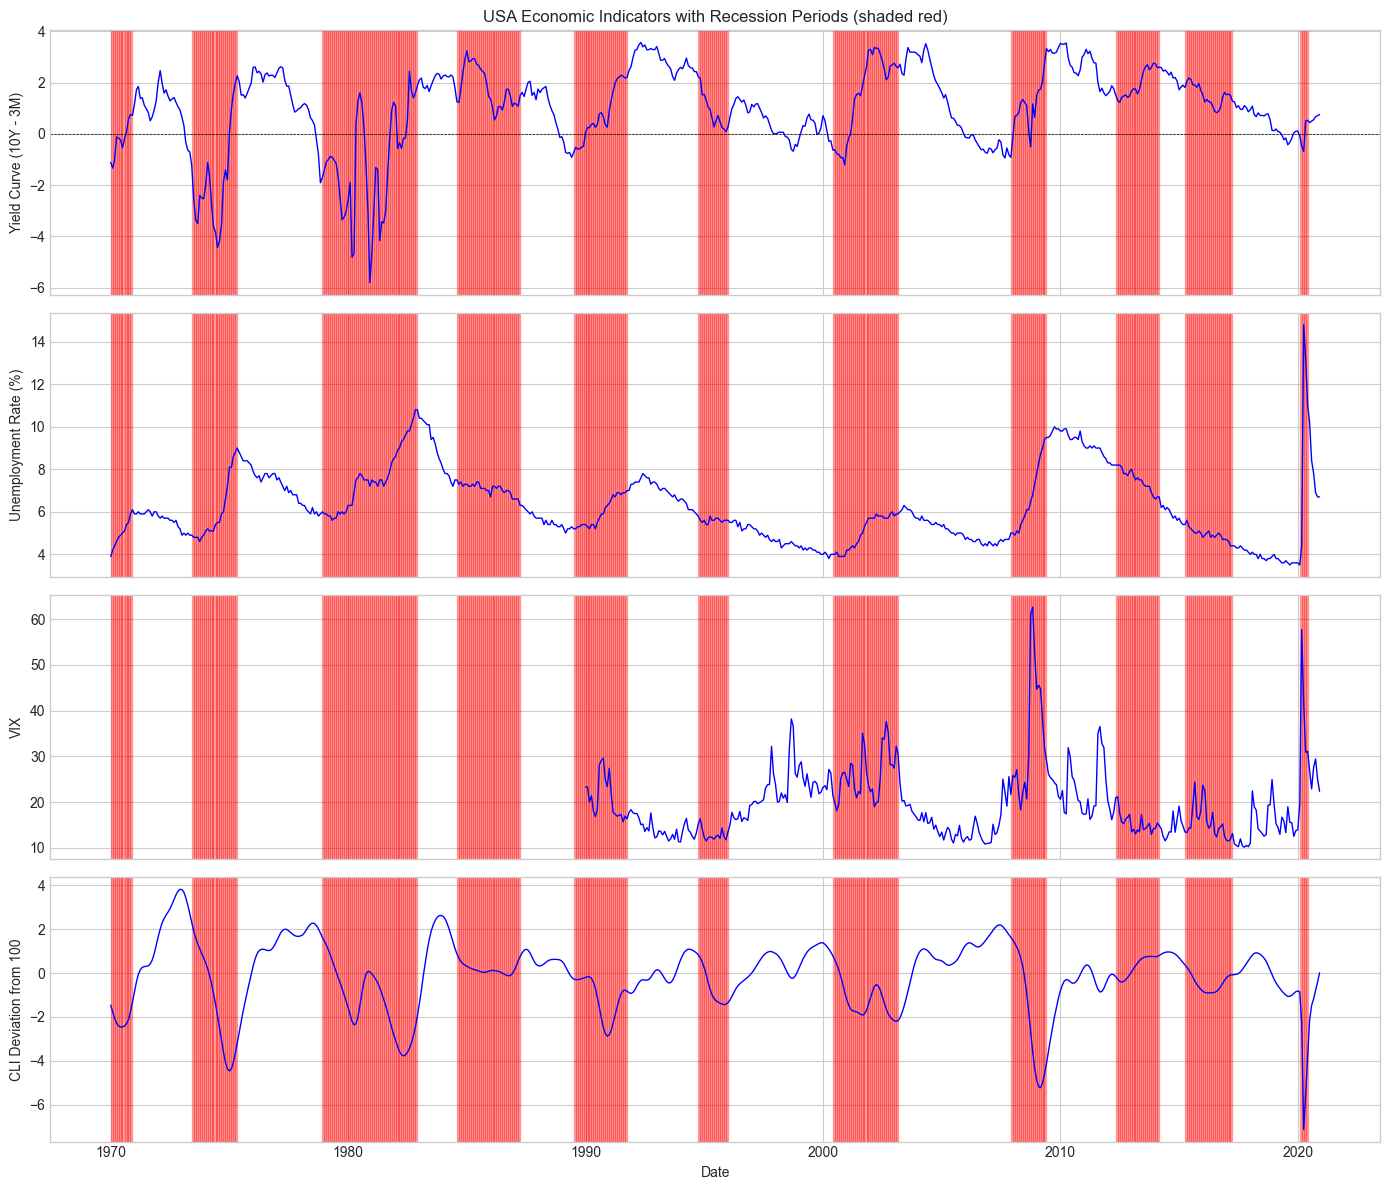

In [11]:
# Plot key indicators over time for USA with recession shading
usa_df = df.xs('USA', level='country')

fig, axes = plt.subplots(4, 1, figsize=(14, 12), sharex=True)

indicators = ['yield_curve', 'unemployment_rate', 'vix', 'cli_dev']
titles = ['Yield Curve (10Y - 3M)', 'Unemployment Rate (%)', 'VIX', 'CLI Deviation from 100']

for ax, indicator, title in zip(axes, indicators, titles):
    if indicator in usa_df.columns:
        ax.plot(usa_df.index, usa_df[indicator], 'b-', linewidth=1)
        ax.set_ylabel(title)
        
        # Shade recession periods
        recession_mask = usa_df['oecd_rec'] == True
        for date in usa_df[recession_mask].index:
            ax.axvspan(date, date + pd.DateOffset(months=1), alpha=0.3, color='red')
        
        # Add zero line for yield curve
        if indicator == 'yield_curve':
            ax.axhline(y=0, color='black', linestyle='--', linewidth=0.5)

axes[0].set_title('USA Economic Indicators with Recession Periods (shaded red)')
axes[-1].set_xlabel('Date')
plt.tight_layout()
plt.show()

### 6. Pre-Recession vs Normal Periods

C:\Users\Matthew\AppData\Local\Temp\ipykernel_44648\596729164.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[i].boxplot([normal, pre_rec], labels=['Normal', 'Pre-Recession'])
C:\Users\Matthew\AppData\Local\Temp\ipykernel_44648\596729164.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[i].boxplot([normal, pre_rec], labels=['Normal', 'Pre-Recession'])
C:\Users\Matthew\AppData\Local\Temp\ipykernel_44648\596729164.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[i].boxplot([normal, pre_rec], labels=['Normal', 'Pre-Recession'])
C:\Users\Matthew\AppData\Local\Temp\ipykernel_44648\596729164.py:13

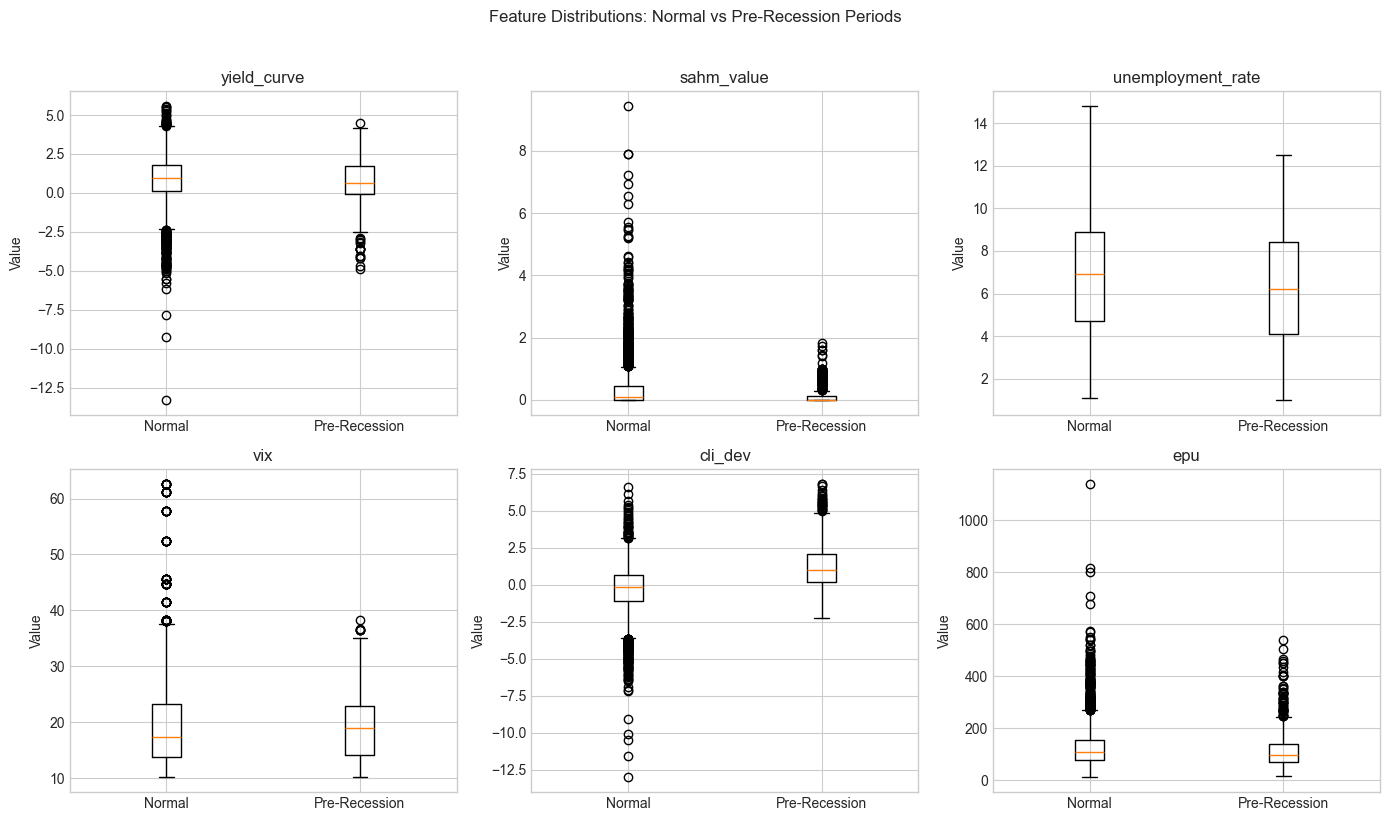

In [12]:
# Compare feature distributions by target class
comparison_features = ['yield_curve', 'sahm_value', 'unemployment_rate', 'vix',
                       'cli_dev', 'epu']
comparison_features = [c for c in comparison_features if c in df.columns]

fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()

for i, col in enumerate(comparison_features):
    normal = df[df['pre_recession'] == 0][col].dropna()
    pre_rec = df[df['pre_recession'] == 1][col].dropna()
    
    axes[i].boxplot([normal, pre_rec], labels=['Normal', 'Pre-Recession'])
    axes[i].set_title(col)
    axes[i].set_ylabel('Value')

plt.suptitle('Feature Distributions: Normal vs Pre-Recession Periods', y=1.02)
plt.tight_layout()
plt.show()

In [13]:
# Statistical comparison of means
print("Mean values by target class:")
comparison_stats = df.groupby('pre_recession')[comparison_features].mean().T
comparison_stats.columns = ['Normal', 'Pre-Recession']
comparison_stats['Difference'] = comparison_stats['Pre-Recession'] - comparison_stats['Normal']
comparison_stats['Pct_Change'] = (comparison_stats['Difference'] / comparison_stats['Normal'].abs() * 100).round(1)
print(comparison_stats.round(3))

Mean values by target class:
                    Normal  Pre-Recession  Difference  Pct_Change
yield_curve          0.849          0.721      -0.128       -15.1
sahm_value           0.387          0.119      -0.268       -69.3
unemployment_rate    6.830          6.384      -0.446        -6.5
vix                 19.592         19.057      -0.535        -2.7
cli_dev             -0.314          1.140       1.454       462.9
epu                132.090        117.713     -14.378       -10.9


### 7. Country Comparisons

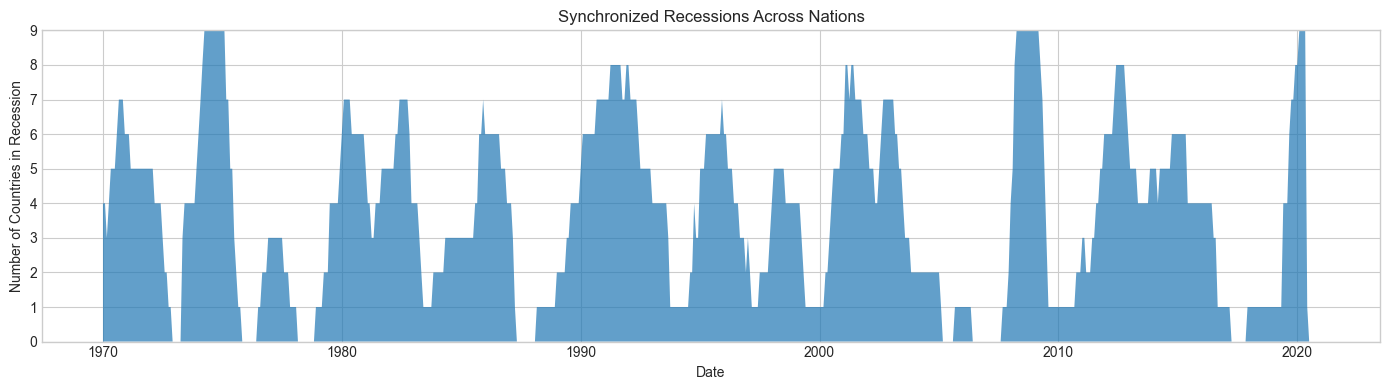


Maximum synchronized recessions: 9
Months with 5+ countries in recession: 239


In [40]:
# Count synchronized recessions (how many countries in recession at same time)
recession_by_date = df.groupby(level='date')['oecd_rec'].sum()

fig, ax = plt.subplots(figsize=(14, 4))
ax.fill_between(recession_by_date.index, recession_by_date.values, alpha=0.7)
ax.set_xlabel('Date')
ax.set_ylabel('Number of Countries in Recession')
ax.set_title('Synchronized Recessions Across Nations')
ax.set_ylim(0, 9)
plt.tight_layout()
plt.show()

print("\nMaximum synchronized recessions:", int(recession_by_date.max()))
print("Months with 5+ countries in recession:", (recession_by_date >= 5).sum())

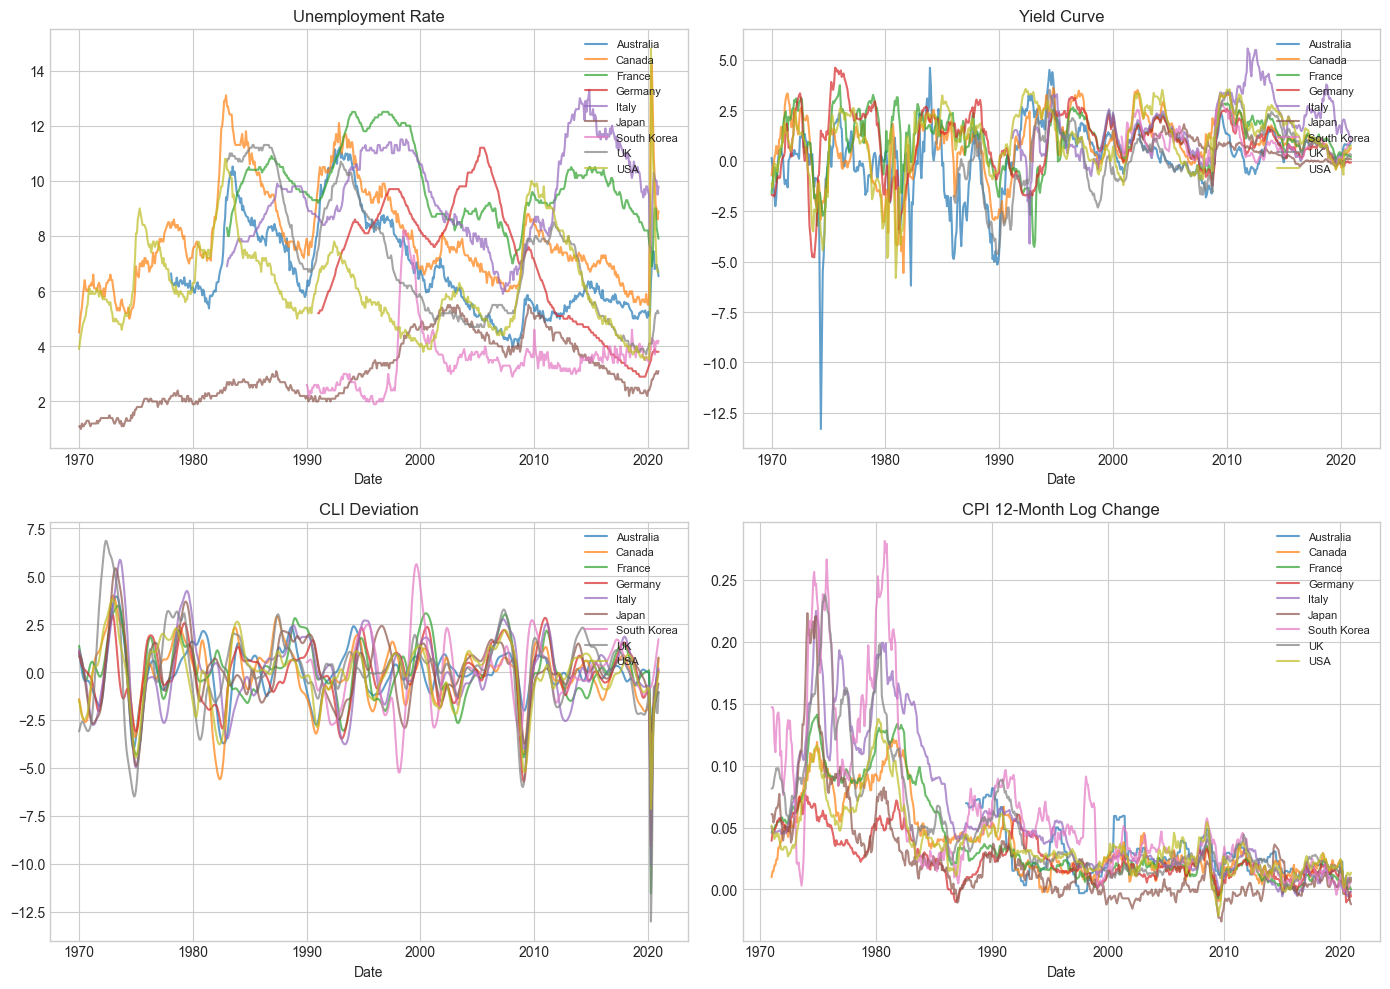

In [15]:
# Compare key indicators across countries
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

indicators = ['unemployment_rate', 'yield_curve', 'cli_dev', 'cpi_log_12mo']
titles = ['Unemployment Rate', 'Yield Curve', 'CLI Deviation', 'CPI 12-Month Log Change']

for ax, indicator, title in zip(axes.flatten(), indicators, titles):
    if indicator in df.columns:
        for country in df.index.get_level_values('country').unique():
            country_data = df.xs(country, level='country')[indicator]
            ax.plot(country_data.index, country_data, label=country, alpha=0.7)
        ax.set_title(title)
        ax.set_xlabel('Date')
        ax.legend(loc='upper right', fontsize=8)

plt.tight_layout()
plt.show()

### 8. Yield Curve Analysis

In [16]:
# Analyze yield curve inversions and their lead time to recessions
print("Yield Curve Inversion Analysis by Country:")
print("="*60)

for country in df.index.get_level_values('country').unique():
    country_df = df.xs(country, level='country').copy()
    
    # Find inversion periods
    inversions = country_df[country_df['yield_curve'] < 0].index
    
    # Find recession starts
    rec = country_df['oecd_rec'].astype(int)
    recession_starts = rec.index[(rec == 1) & (rec.shift(1) == 0)]
    
    print(f"\n{country}:")
    print(f"  Total months with inverted yield curve: {len(inversions)}")
    print(f"  Number of recessions: {len(recession_starts)}")
    
    # For each recession, find if there was a preceding inversion
    for rec_start in recession_starts:
        # Look back 24 months for inversions
        lookback_start = rec_start - pd.DateOffset(months=24)
        preceding_inversions = inversions[(inversions >= lookback_start) & (inversions < rec_start)]
        
        if len(preceding_inversions) > 0:
            first_inversion = preceding_inversions.min()
            lead_months = (rec_start - first_inversion).days // 30
            print(f"  Recession {rec_start.strftime('%Y-%m')}: Inversion {lead_months} months prior")
        else:
            print(f"  Recession {rec_start.strftime('%Y-%m')}: No inversion in prior 24 months")

Yield Curve Inversion Analysis by Country:

Australia:
  Total months with inverted yield curve: 228
  Number of recessions: 13
  Recession 1970-05: Inversion 2 months prior
  Recession 1973-12: Inversion 7 months prior
  Recession 1976-09: Inversion 24 months prior
  Recession 1981-09: Inversion 22 months prior
  Recession 1985-08: Inversion 7 months prior
  Recession 1989-08: Inversion 14 months prior
  Recession 1994-08: No inversion in prior 24 months
  Recession 1999-01: No inversion in prior 24 months
  Recession 2002-07: Inversion 24 months prior
  Recession 2005-09: Inversion 18 months prior
  Recession 2008-02: Inversion 24 months prior
  Recession 2012-06: Inversion 10 months prior
  Recession 2019-12: Inversion 4 months prior

Canada:
  Total months with inverted yield curve: 129
  Number of recessions: 12
  Recession 1974-02: Inversion 6 months prior
  Recession 1976-07: Inversion 24 months prior
  Recession 1981-06: Inversion 24 months prior
  Recession 1985-12: No inversi

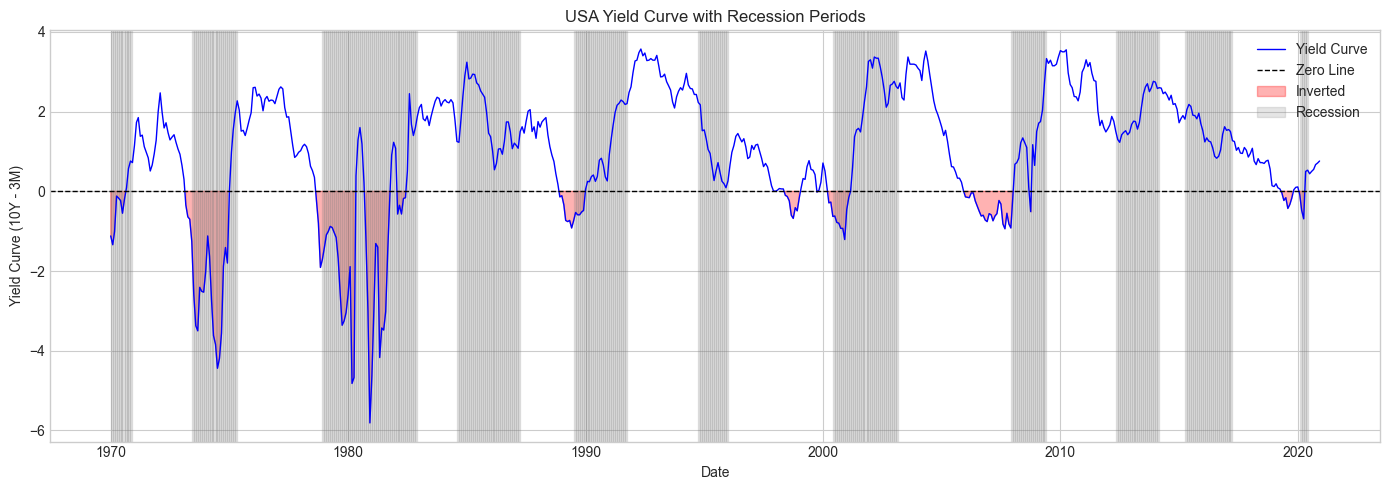

In [17]:
# Visualize yield curve with recession overlay for USA
usa_df = df.xs('USA', level='country')

fig, ax = plt.subplots(figsize=(14, 5))

ax.plot(usa_df.index, usa_df['yield_curve'], 'b-', linewidth=1, label='Yield Curve')
ax.axhline(y=0, color='black', linestyle='--', linewidth=1, label='Zero Line')
ax.fill_between(usa_df.index, usa_df['yield_curve'], 0, 
                where=(usa_df['yield_curve'] < 0), alpha=0.3, color='red', label='Inverted')

# Shade recession periods
recession_mask = usa_df['oecd_rec'] == True
for i, date in enumerate(usa_df[recession_mask].index):
    ax.axvspan(date, date + pd.DateOffset(months=1), alpha=0.2, color='gray',
               label='Recession' if i == 0 else '')

ax.set_xlabel('Date')
ax.set_ylabel('Yield Curve (10Y - 3M)')
ax.set_title('USA Yield Curve with Recession Periods')
ax.legend(loc='upper right')
plt.tight_layout()
plt.show()

### 9. Summary Statistics

In [18]:
# Final summary
print("Dataset Summary")
print("="*60)
print(f"Total observations: {len(df)}")
print(f"Total features: {len(df.columns)}")
print(f"Date range: {df.index.get_level_values('date').min().strftime('%Y-%m')} to {df.index.get_level_values('date').max().strftime('%Y-%m')}")
print(f"Countries: {len(df.index.get_level_values('country').unique())}")
print(f"\nTarget distribution:")
print(f"  Normal periods: {(df['pre_recession'] == 0).sum()} ({(df['pre_recession'] == 0).mean():.1%})")
print(f"  Pre-recession: {(df['pre_recession'] == 1).sum()} ({(df['pre_recession'] == 1).mean():.1%})")
print(f"\nMissing values: {df.isnull().sum().sum()} total across all features")
print(f"Features with no missing: {(df.isnull().sum() == 0).sum()}")

Dataset Summary
Total observations: 5508
Total features: 233
Date range: 1970-01 to 2020-12
Countries: 9

Target distribution:
  Normal periods: 4334 (78.7%)
  Pre-recession: 1174 (21.3%)

Missing values: 269887 total across all features
Features with no missing: 14


### 10. XGBoost Baseline Model

Test a baseline XGBoost classifier with time-based cross-validation. XGBoost handles missing values natively and doesn't require feature scaling.

**Key considerations:**
- **Time-based CV**: Split by date to avoid look-ahead bias (all countries at time t in same fold)
- **Class imbalance**: Use `scale_pos_weight` to handle rare recession events
- **Feature leakage**: Exclude `oecd_rec` and `technical_rec` (these are recession indicators)

In [34]:
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc

# Reset index to work with date column
df_flat = df.reset_index()

# Drop COVID-19 period (2020 onwards) - exogenous shock with different dynamics
df_flat = df_flat[df_flat['date'] < '2020-01-01']
print(f"Filtered to pre-COVID period: {df_flat['date'].min().strftime('%Y-%m')} to {df_flat['date'].max().strftime('%Y-%m')}")

# Identify feature columns (exclude leaky and non-feature columns)
leaky_cols = ['oecd_rec', 'technical_rec', 'pre_recession']
non_feature_cols = ['date', 'country']
feature_cols = [c for c in df_flat.columns if c not in leaky_cols + non_feature_cols]

print(f"Total features: {len(feature_cols)}")
print(f"Total observations: {len(df_flat)}")

X = df_flat[feature_cols].copy()
y = df_flat['pre_recession']

# Replace inf/-inf with NaN (XGBoost handles NaN but not inf)
inf_count = np.isinf(X).sum().sum()
X = X.replace([np.inf, -np.inf], np.nan)
print(f"Replaced {inf_count} infinite values with NaN")

# Handle class imbalance
scale_pos_weight = (y == 0).sum() / (y == 1).sum()
print(f"Class imbalance ratio: {scale_pos_weight:.2f}:1")
print(f"Positive class: {y.sum()} ({y.mean():.1%})")

Filtered to pre-COVID period: 1970-01 to 2019-12
Total features: 230
Total observations: 5400
Replaced 471 infinite values with NaN
Class imbalance ratio: 3.60:1
Positive class: 1173 (21.7%)


In [35]:
# Investigate Fold 5 issue: check pre-recession labels in 2019
df_check = df.reset_index()
df_2019 = df_check[(df_check['date'] >= '2019-01-01') & (df_check['date'] < '2020-01-01')]
print("2019 Pre-recession labels (these precede COVID recessions):")
print(f"  Total 2019 observations: {len(df_2019)}")
print(f"  Labeled as pre_recession=1: {df_2019['pre_recession'].sum()} ({df_2019['pre_recession'].mean():.1%})")
print(f"\nBy country:")
print(df_2019.groupby('country')['pre_recession'].agg(['sum', 'mean']).round(2))

# Option: Also exclude 2019 (pre-COVID contamination)
print("\n" + "="*60)
print("Re-running with 2019 also excluded (pre-COVID contamination)...")
print("="*60)

df_flat_clean = df.reset_index()
df_flat_clean = df_flat_clean[df_flat_clean['date'] < '2019-01-01']

X_clean = df_flat_clean[feature_cols].copy()
y_clean = df_flat_clean['pre_recession']
X_clean = X_clean.replace([np.inf, -np.inf], np.nan)

scale_pos_weight_clean = (y_clean == 0).sum() / (y_clean == 1).sum()

model_clean = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight_clean,
    random_state=42,
    n_jobs=-1,
    verbosity=0
)

tscv = TimeSeriesSplit(n_splits=5)
cv_results_clean = []

for fold, (train_idx, test_idx) in enumerate(tscv.split(X_clean)):
    X_train, X_test = X_clean.iloc[train_idx], X_clean.iloc[test_idx]
    y_train, y_test = y_clean.iloc[train_idx], y_clean.iloc[test_idx]
    
    train_dates = df_flat_clean.iloc[train_idx]['date']
    test_dates = df_flat_clean.iloc[test_idx]['date']
    
    model_clean.fit(X_train, y_train)
    y_proba = model_clean.predict_proba(X_test)[:, 1]
    
    roc_auc = roc_auc_score(y_test, y_proba)
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall, precision)
    
    cv_results_clean.append({'fold': fold + 1, 'roc_auc': roc_auc, 'pr_auc': pr_auc})
    
    print(f"Fold {fold + 1}: Train to {train_dates.max().strftime('%Y-%m')}, Test {test_dates.min().strftime('%Y-%m')}-{test_dates.max().strftime('%Y-%m')} | ROC-AUC: {roc_auc:.3f} | PR-AUC: {pr_auc:.3f}")

results_clean_df = pd.DataFrame(cv_results_clean)
print(f"\nSummary (excluding 2019+):")
print(f"  Mean ROC-AUC: {results_clean_df['roc_auc'].mean():.3f} ± {results_clean_df['roc_auc'].std():.3f}")
print(f"  Mean PR-AUC:  {results_clean_df['pr_auc'].mean():.3f} ± {results_clean_df['pr_auc'].std():.3f}")

2019 Pre-recession labels (these precede COVID recessions):
  Total 2019 observations: 108
  Labeled as pre_recession=1: 62 (57.4%)

By country:
             sum  mean
country               
Australia     11  0.92
Canada         8  0.67
France         5  0.42
Germany        0  0.00
Italy          5  0.42
Japan          5  0.42
South Korea    9  0.75
UK             8  0.67
USA           11  0.92

Re-running with 2019 also excluded (pre-COVID contamination)...
Fold 1: Train to 1978-02, Test 1978-03-1986-04 | ROC-AUC: 0.677 | PR-AUC: 0.428
Fold 2: Train to 1986-04, Test 1986-05-1994-06 | ROC-AUC: 0.705 | PR-AUC: 0.286
Fold 3: Train to 1994-06, Test 1994-07-2002-08 | ROC-AUC: 0.749 | PR-AUC: 0.511
Fold 4: Train to 2002-08, Test 2002-09-2010-10 | ROC-AUC: 0.785 | PR-AUC: 0.473
Fold 5: Train to 2010-10, Test 2010-11-2018-12 | ROC-AUC: 0.624 | PR-AUC: 0.320

Summary (excluding 2019+):
  Mean ROC-AUC: 0.708 ± 0.063
  Mean PR-AUC:  0.404 ± 0.097


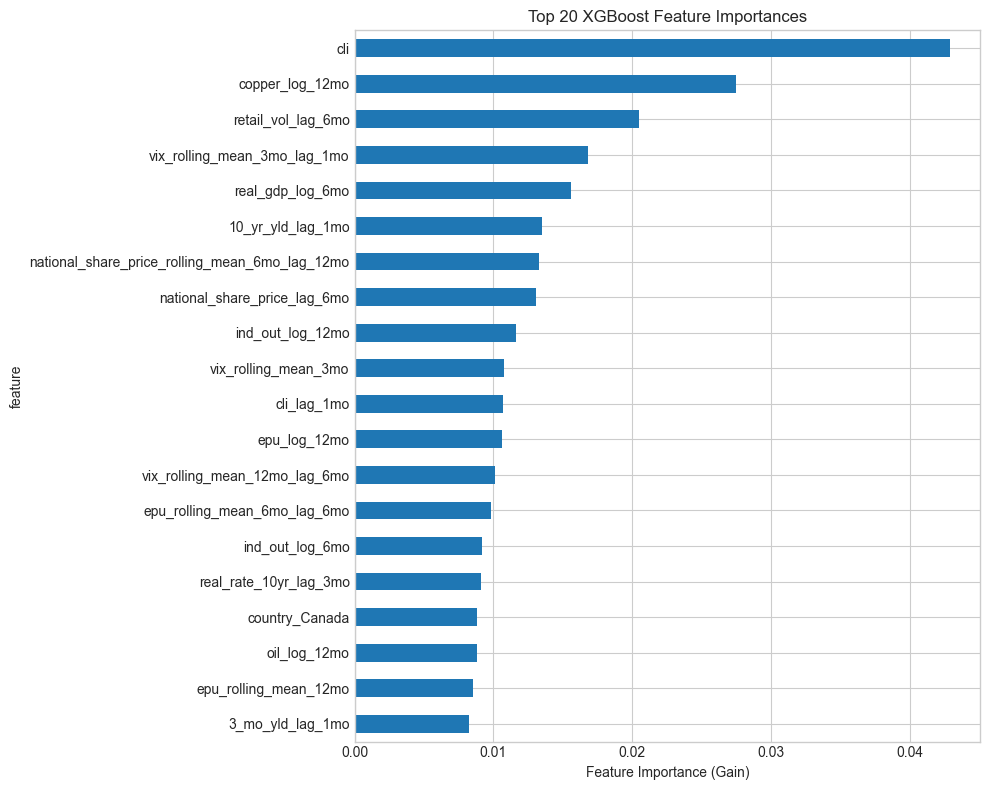


Top 10 most important features:
                                       feature  importance
                                           cli    0.042915
                               copper_log_12mo    0.027485
                            retail_vol_lag_6mo    0.020523
                  vix_rolling_mean_3mo_lag_1mo    0.016795
                              real_gdp_log_6mo    0.015616
                             10_yr_yld_lag_1mo    0.013528
national_share_price_rolling_mean_6mo_lag_12mo    0.013259
                  national_share_price_lag_6mo    0.013044
                              ind_out_log_12mo    0.011659
                          vix_rolling_mean_3mo    0.010764


In [36]:
# Feature importance from the last fold model
importances = pd.DataFrame({
    'feature': feature_cols,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

# Plot top 20 features
fig, ax = plt.subplots(figsize=(10, 8))
top_n = 20
importances.head(top_n).plot(
    kind='barh', 
    x='feature', 
    y='importance', 
    ax=ax, 
    legend=False
)
ax.set_xlabel('Feature Importance (Gain)')
ax.set_title(f'Top {top_n} XGBoost Feature Importances')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

print(f"\nTop 10 most important features:")
print(importances.head(10).to_string(index=False))

#### XGBoost Baseline Summary

**Model Configuration:**
- XGBoost classifier with default hyperparameters (100 trees, max_depth=6, lr=0.1)
- `scale_pos_weight` to handle class imbalance
- Time-series cross-validation with 5 expanding window folds

**Key Observations:**
- XGBoost handles missing values natively - no imputation needed
- Time-based CV prevents look-ahead bias (critical for forecasting tasks)
- PR-AUC is more informative than ROC-AUC for imbalanced classes

**Next Steps for Improvement:**
1. Hyperparameter tuning (max_depth, learning_rate, n_estimators)
2. Feature selection based on importance scores
3. Try alternative thresholds based on precision-recall trade-offs
4. Compare with other models (Logistic Regression, Random Forest, LightGBM)